In [1]:
## loading python libraries

# necessary to display plots inline:
%matplotlib inline

# load the libraries
import matplotlib.pyplot as plt # 2D plotting library
import numpy as np              # package for scientific computing

from scipy.optimize import fsolve   # Numerically solve non-linear system of equations
from scipy.optimize import minimize # Numerically minimize scalar multivariable function

from math import *              # package for mathematics (pi, arctan, sqrt, factorial ...)

import cv2                      # In case I have to write code similar to that of Wu Yifan
import os
import matplotlib.animation as ani
import sympy as sp
import utils                    # Wu Yifan's image/video processing functions

In [2]:
import threading                # MultiThreading

In [3]:
utils.initialize()  #Initialize directories (if they don't exist)

In this Jupyter Notebook, I record my first attempt at numerically minimizing the potential energy to predict the stretch of the cornea under an airpuff exam. We first tackle the two dimensional problem; that is, the cornea as observed in the tonometer generated image.

In this specific, initial 2D problem and after evaluation of my approach with Dr. Allain, we discretize our 2D cornea of thickness that we overlook for now into $N+1$ segments.

We also neglect the energy arising from bending for now, and only consider energy from stretch. In other words, there is no energy cost associated to acute angles forming between our segments just yet. We further assume that, for now, the cornea longitudinal stiffness is uniform. However, we must later account for the fact that even in this model, the relative stiffness of a segment depends on its length (we will quickly change to Young's modulus or another quantity.)

In [4]:
N = 100
K = np.ones(N+1)  # Subject to change after careful analysis - Vector for N+1 segments

The approach is as follows:

- We descretize our cornea in the first tonometer frame (before the air puff reaches the cornea) into $N+1$ segments by tagging $N+2$ nodes on the cornea and tracking their vertical positions and fixed horizontal positions. The first and last nodes are clamped at the beginning and end of the cornea.

- At a given time throughout the experiment, we can retrieve the vertical displacements of the cornea at the fixed horizontal positions from the tonometer frame in question, so we're left with $N$ unknown, desired parameters; the horizontal displacements of the $N$ nodes that are nt the first and last nodes.

- Upon properly writing the potential energy in terms of the node positions/displacements at a given time, we can then use the principle of minimum potential energy and solve a system of equations to find a set of horizontal displacements which extremizes the potential energy by using numerical methods to solve a system of $N$ equations.

The challenge at hand is properly writing the potential energy $U_s$ associated to the segment stretches in terms of the recorded vertical displacement and the desired unknowns.

We make the following observations on our methodology, and we assume that our approach is to write the total energy as the sum of the elastic energies of the segments parametrized by the node positions.
- Firstly, we have to track the nodes as points along the cornea, as their initial and final separation dictates the stress of the cornea.
- With this treatment of the tonometer image, we can only track the vertical fluctuation at a fixed horizontal position.
- An apparent problem is that, when trying to minimize $U_s$ written in terms of the new vertical displacements, the length I intend to subtract is the orginal segment length given in the first frame, but this requires me to use the vertical positions of the nodes - and not at the fixed horizontal positions - in order to compute the new segment length.

We illustrate this last point below, where $i=0,1,...,N,N+1$ (to represent all unclamped nodes and the two clamped nodes at the extremeties.)

Say we denote $x_i$ the initial, known, horizontal positions of the nodes we tag along the cornea. We interested in the $u_i$ values where $x_i+u_i$ is the new horizontal position of the node after some work by the air puff. We recall that we are seeking the elastic deformation, and consequently the displacement fields. We denote $y_{0,i}$ and $y_i$ respectively the initial and final vertical positions measured at the $x_i$ positions (at the beginning an din the frame of interest.) From the initial $(x_i,y_i)$, we fetch the initial segment lengths, which we denote $l_{0,i}$. Now, we write (using $\Delta$ to denote the difference with respect to previous node and up to properly taking the limits of partial sum):


$$
U_s = \sum_i \frac{1}{2}K \: \left(\sqrt{(\Delta x_i +\Delta u_i)^2+(\Delta y_i)^2}-l_{0,i}\right)^2
$$

The problem we have is that for the above expression to be correct, the $y_i$ values must correspond to the node vertical positions, not the tagged vertical positions. Otherwise, all other values must be associated to this new sgement, and we've essentially restarted the porblem with new nodes.

To this end, we could use a straight-line approximation; we could extrapolate the appropriate vertical positions to take by using the slope of the segment and adding $u_i\cdot$slope to $y_i$. This approximations is an illustration of the assumption that, on a fine enough discretization, the cornea portion can be modelled by a rectilinear segment, which is not outrageous considering that our initial segment discretization relies on a similar assumption (we do not have an analytical curve of the cornea without using the intra-ocular pressure and true mechanical properties of the cornea.)

Hence, at this stage, our total elastic potential energy writes (accoutning for variable segment stiffness depending on the initial discretization):

$$
U_s = \sum_{i=1}^{N+1} \frac{1}{2}K_i \: \left(\sqrt{(x_i-x_{i-1} + u_i-u_{i-1})^2+\left(y_i+u_i \frac{y_i-y_{i-1}}{x_i-x_{i-1}}-y_{i-1}-u_{i-1} \frac{y_i-y_{i-1}}{x_i-x_{i-1}}\right)^2}-l_{0,i}\right)^2
$$

$$
u_0 = u_{N+1}= 0
$$

We now employ the principal of minimum potential energy and take the partial derivatives of this potential with respect to its $N$ variables $(u_i)_{i=1,...,N}$ - nodes $0$ and $N+1$ are clamped - and we get the following.

$$
\frac{\partial U_s}{\partial u_i} = K_i \: \left(\sqrt{(x_i-x_{i-1} + u_i-u_{i-1})^2+\left(y_i+u_i \frac{y_i-y_{i-1}}{x_i-x_{i-1}}-y_{i-1}-u_{i-1} \frac{y_i-y_{i-1}}{x_i-x_{i-1}}\right)^2}-l_{0,i}\right)
\times
\frac{(x_i-x_{i-1}+u_i-u_{i-1})+\left(y_i+u_i \frac{y_i-y_{i-1}}{x_i-x_{i-1}}-y_{i-1}-u_{i-1} \frac{y_i-y_{i-1}}{x_i-x_{i-1}}\right)\cdot \frac{y_i-y_{i-1}}{x_i-x_{i-1}} }{\sqrt{(x_i-x_{i-1} + u_i-u_{i-1})^2+\left(y_i+u_i \frac{y_i-y_{i-1}}{x_i-x_{i-1}}-y_{i-1}-u_{i-1} \frac{y_i-y_{i-1}}{x_i-x_{i-1}}\right)^2}}
$$
$$
-K_{i+1} \: \left(\sqrt{(x_{i+1}-x_{i} + u_{i+1}-u_{i})^2+\left(y_{i+1}+u_{i+1} \frac{y_{i+1}-y_{i}}{x_{i+1}-x_{i}}-y_{i}-u_{i} \frac{y_{i+1}-y_{i}}{x_{i+1}-x_{i}}\right)^2}-l_{0,i+1}\right)
\times
\frac{(x_{i+1}-x_{i}+u_{i+1}-u_{i})+\left(y_{i+1}+u_{i+1} \frac{y_{i+1}-y_{i}}{x_{i+1}-x_{i}}-y_{i}-u_{i} \frac{y_{i+1}-y_{i}}{x_{i+1}-x_{i}}\right)\cdot \frac{y_{i+1}-y_{i}}{x_{i+1}-x_{i}} }{\sqrt{(x_{i+1}-x_{i} + u_{i+1}-u_{i})^2+\left(y_{i+1}+u_{i+1} \frac{y_{i+1}-y_{i}}{x_{i+1}-x_{i}}-y_{i}-u_{i} \frac{y_{i+1}-y_{i}}{x_{i+1}-x_{i}}\right)^2}}
$$

One must observe in the two above expressions that $y_i$ is extrapolated twice - once using the slope of the left segment, and once using the slope of the right segment. Perhaps this can serve as a weighting effect since after all this extrapolation is an approximation. Also, provided our discretization is fine enough, the slope of two consecutive segments should not be enormously different (the difference reaches a maximum at the apex and even then if we have small enough segments it should be fine.) Dr. Allain has mentioned marginal optimization of this accuracy using a second degree polynomial interpolation, that will possibly be implemented toward the end of this 2D problem's completion.

The above expression is neither linear nor pretty, but we can use scipy.optimize.fsolve to numerically solve the system of $N$ equations corresponding to the extremization of the potential energy. We expect two terms as two segments are affected by a single node's movement, with the associated energy costs weighted by the segment stiffness (which is turn defined by how we discretize the cornea.)

At this stage, we can start by writing a function which, given an array of $y_i$ values and $K_i$ values, can prepare our input vectors for fsolve to yield $u_i$ solutions which minimize the potential energy.

In [5]:
def initialLengthsFinder(x_0, y_0):  #Returns the N+1 segment Lengths, take N+2
                                     #node coordinates
    lengths = np.zeros(N+1)
    for i in range(x_0.shape[0]-1):
        length = sqrt((x_0[i]-x_0[i+1])**2 +(y_0[i]-y_0[i+1])**2)
        lengths[i] = length
    return lengths

We now write the function that will be passed to scipy.optimize.fsolve .

In [6]:
def euclideanDistance(xy_1, xy_2): #probably existing function
    return sqrt(((xy_1[0]-xy_2[0])**2)+((xy_1[1]-xy_2[1])**2))

In [7]:
def slope(xy1, xy2):
    return (xy2[1] - xy1[1]) / (xy2[0] - xy1[0])

In [8]:
def partialsVectorFunction(u_i, x_0, y_i, lengths, K):   #to pass to fsolve - N sized (unclamped nodes)

    u = np.zeros(N+2)
    for i in range(u_i.shape[0]):
        u[i+1] = u_i[i]

    y = y_i

    x= x_0

    Lengths = np.zeros(N+2)

    for j in range(N+1):
        Lengths[j+1] = lengths[j]   #for the sake of clarity (array sizes)

    newK = np.zeros(N+2)

    for l in range(N+1):
        newK[l+1] = K[l]   #for the sake of clarity (array sizes)

    finalVectorNotCut = np.zeros(u.shape[0])

    for k in range(1, u.shape[0]-1):
        slopeLeft = slope((x[k-1], y[k-1]),(x[k],y[k]))
        slopeRight = slope((x[k],y[k]),(x[k+1],y[k+1]))
        leftK = newK[k]
        rightK = newK[k+1]
        leftLen = Lengths[k]
        rightLen = Lengths[k+1]   #clarity per iteration

        leftEucTuple_y2 = y[k]+u[k]*slopeLeft
        leftEucTuple_x2 = x[k]+u[k]

        leftEucTuple_xy2 = (leftEucTuple_x2, leftEucTuple_y2)

        leftEucTuple_y1 = y[k-1]+ u[k-1]*slopeLeft
        leftEucTuple_x1 = x[k-1]+u[k-1]

        leftEucTuple_xy1 = (leftEucTuple_x1, leftEucTuple_y1)

        leftEuc = euclideanDistance(leftEucTuple_xy1, leftEucTuple_xy2) #first square root

        RightEucTuple_y2 = y[k+1] + u[k+1]*slopeRight
        RightEucTuple_x2 = x[k+1]+u[k+1]

        RightEucTuple_xy2 = (RightEucTuple_x2, RightEucTuple_y2)

        RightEucTuple_y1 = y[k] + u[k]*slopeRight
        RightEucTuple_x1 = x[k]+u[k]

        RightEucTuple_xy1 = (RightEucTuple_x1, RightEucTuple_y1)

        RightEuc = euclideanDistance(RightEucTuple_xy1, RightEucTuple_xy2) #second square root

        #now to actually compute this component of the final vector

        leftTerm = (leftK*(leftEuc - leftLen))/leftEuc
        leftTerm = leftTerm * (leftEucTuple_x2-leftEucTuple_x1 + (leftEucTuple_y2-leftEucTuple_y1)*slopeLeft)

        rightTerm = (rightK*(RightEuc - rightLen))/RightEuc
        rightTerm = rightTerm *(RightEucTuple_x2-RightEucTuple_x1 + (RightEucTuple_y2-RightEucTuple_y1)*slopeRight)

        finalVectorNotCut[k] = leftTerm - rightTerm

    return finalVectorNotCut[1: N+1]


Provided the above was written correctly, we can pass this function along with an initial guess (zeros or half the initial length) for the displacements to scipy.optimize.fsolve and we can get a numerical solution for our displacements.

Before we write a code to tag nodes on a tonometer capture, let us see if we get reasonable results for a parabola that is deformed into a 4th degree polynomial with negative leading coefficient (just a small sanity check)

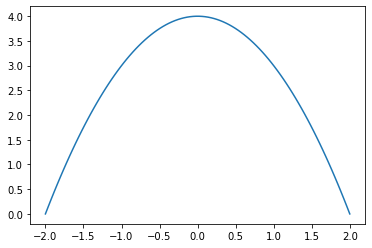

In [9]:
x = np.linspace(-2,2, N+2) # N+2 Nodes x positions, with clamped extremities
y_0 = -x**2 +4             # initial vertical node locations

plt.figure(figsize = (6,4))
plt.plot(x, y_0)
plt.show()

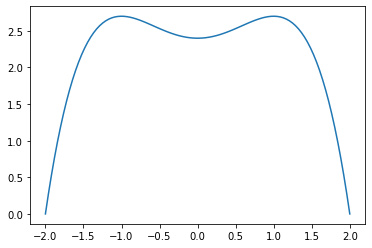

In [10]:
y = 0.3*(-((x**2 -1 )**2 +1)+10)
plt.figure(figsize = (6,4))
plt.plot(x, y)
plt.show()

In [11]:
lengths = initialLengthsFinder(x, y_0)

In [12]:
u = fsolve(partialsVectorFunction, np.zeros(N), args = (x,y,lengths, K))  #We ignore the fact that K isn't proper here
u # looks fine?

array([-0.01706865, -0.0329358 , -0.047502  , -0.06065732, -0.07228029,
       -0.08223686, -0.09037942, -0.09654616, -0.10056088, -0.10223376,
       -0.1013637 , -0.09774304, -0.09116623, -0.08144388, -0.06842468,
       -0.05202691, -0.03228017, -0.00937432,  0.01629446,  0.04409893,
        0.07319981,  0.10262171,  0.13137305,  0.15857016,  0.18352305,
        0.20576376,  0.22502746,  0.24120928,  0.2543165 ,  0.26442714,
        0.27165838,  0.27614463,  0.27802326,  0.27742608,  0.27447482,
        0.26927928,  0.26193747,  0.25253706,  0.24115786,  0.22787518,
        0.21276399,  0.19590361,  0.17738305,  0.15730643,  0.13579834,
        0.11300832,  0.08911398,  0.06432189,  0.03886566,  0.01300115,
       -0.01300115, -0.03886566, -0.06432189, -0.08911398, -0.11300832,
       -0.13579834, -0.15730643, -0.17738305, -0.19590361, -0.21276399,
       -0.22787518, -0.24115786, -0.25253706, -0.26193747, -0.26927928,
       -0.27447482, -0.27742608, -0.27802326, -0.27614463, -0.27

I think the values look okay in terms of order of magnitude and symmetry.

Hence, we can now apply it to our cornea movies, but we must first write a function which computes the total potential energy given we've found the new node locations.

Observe that the double extrapolation of $y$ will not pose a problem since, after finding the nodes' horizontal displacements with fsolve, we simply tag the vertical displacment at these new x positions.

The function below - which computes the potential energy - will take the final nodes' horizontal **positions** (initial x + u), an array of size N+2 so it includes the clamped nodes. It also takes the new, tagged vertical positions as parametrized by the new horizontal postions along the cornea, the stiffnesses of the segments, and the initial lengths of the segment sbefore deformation.

In [13]:
def potentialEnergyCompute(newx, newy, K, initialLengths):
  """
  Takes:

   - newx: final node x coordinates size N+2
   - newy: final node y coordinates size N+2
   - K: segment stiffnesses size N+1
   - initialLengths: segment initial lengths to compute gain in elastic potential energy size N+1

  """

  newLengths =  initialLengthsFinder(newx,newy)  #Misleading function name unfortunately - I've just realized this

  #Now we use the above expression of U_s and simply translate to Python code

  segmentEnergies = 0.5*K*(newLengths- initialLengths)**2

  return np.sum(segmentEnergies)

In addition to the above, we will write the potential energy function to minimize and use scipy.optimize.minimize rather than fsolve - it is directly aligned with our goal and does not require the intermediate differentiation, so it would good practice to directly pass it by that.

In [14]:
def potentialEnergy(u_i, x_0, y_i, lengths, K):
    
    segmentEnergies = np.zeros(N+1)        #To sum at the end
    x = x_0
    y = y_i
    u = np.zeros(N+2)
    
    for j in range(u.shape[0]-2):
        u[j+1] = u_i[j]
        
    for i in range(K.shape[0]):
        
        Slope = slope((x[i],y[i]),(x[i+1],y[i+1]))
        
        p1 = (x[i]+u[i], y[i]+Slope*u[i])
        p2 = (x[i+1]+u[i+1], y[i+1] + Slope*u[i+1])
        
        newDist = euclideanDistance(p1, p2)
        
        segmentEnergies[i] = 0.5 * K[i] * (newDist - lengths[i])**2
    
    return np.sum(segmentEnergies)
        
        
        
    

In [15]:
u_min = minimize(potentialEnergy, np.zeros(N), args = (x,y,lengths, K))  #We ignore the fact that K isn't proper here
u_min.x # looks fine?

array([-0.01706869, -0.03293596, -0.0475023 , -0.06065765, -0.07228071,
       -0.08223731, -0.09037994, -0.09654675, -0.10056155, -0.10223455,
       -0.10136457, -0.09774404, -0.09116724, -0.08144466, -0.06842543,
       -0.05202774, -0.03228166, -0.00937647,  0.01629199,  0.0440964 ,
        0.07319861,  0.10262031,  0.13137093,  0.15856786,  0.18352138,
        0.20576131,  0.22502401,  0.24120468,  0.25431229,  0.26442391,
        0.27165603,  0.27614209,  0.27801978,  0.27742182,  0.2744705 ,
        0.26927548,  0.26193326,  0.25253228,  0.24115298,  0.22787041,
        0.21276043,  0.19590076,  0.17737909,  0.15730085,  0.13579302,
        0.11300382,  0.08911035,  0.06431778,  0.03886082,  0.01299671,
       -0.01300342, -0.03886755, -0.06432451, -0.08911711, -0.11301061,
       -0.13579984, -0.1573077 , -0.17738597, -0.19590767, -0.21276735,
       -0.22787735, -0.24115991, -0.2525392 , -0.26194016, -0.26928233,
       -0.27447733, -0.27742853, -0.27802645, -0.27614863, -0.27

It is quite reassuring to see that both of the above methods yield similar results. Moreover, scipy.optimize.minimize actually accepts a bunch of additional parameters such as bounds and constraints which we can later leverage to our advantage.

At this stage, we will focus on properly treating the videos before designing the pipeline to extract the potential energy time evolution.

In [16]:
def getFrames(video_name):
    if not(os.path.exists("Data/video"+video_name+"/")):
        utils.video_to_image(video_name)
    else:
        print("Frames already extracted, delete directory to repeat.")

In [17]:
getFrames("001BA_Left_20160203_132002.avi")

Frames already extracted, delete directory to repeat.


In [18]:
def treatImagesInPlace(video_name):
    
    imagesLocation = "Data/video"+video_name+"/"
    if not(os.path.exists("Data/video"+video_name+"_TREATED/")):
        os.mkdir("Data/video"+video_name+"_TREATED/")
    else:
        print("Already treated, delete directrory to repeat.")
        return
    
    
    for i in os.listdir(imagesLocation):
        imageLoc = imagesLocation+i
        toTreat = cv2.imread(imageLoc)
        image = utils.image_processing(toTreat)
        cv2.imwrite("Data/video"+video_name+"_TREATED/"+i, image)

In [19]:
treatImagesInPlace("001BA_Left_20160203_132002.avi")    #utils.py can be optimized

Already treated, delete directrory to repeat.


We must now properly tag nodes and find the total stretch energy on each frame (chronologically) before making a $U$ versus $t$ graph. The time between frames can easily be retrieved from parameters in utils.py .

We can use the code written by Wu Yifan to get the median line first and work with that line, as what would happen if I decided to work directly with the images would result in something analogous to this median line construction.

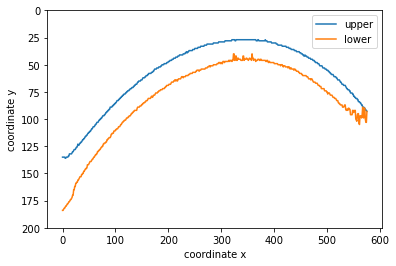

In [20]:
img2 = "Data/video"+"001BA_Left_20160203_132002.avi"+"_TREATED/"+"image1.jpg"
img = cv2.imread(img2)
img = utils.image_processing(img)
waveform = utils.get_waveform(img, output = True)   #TESTING

Let us write a general function to get the middle line of a cornea waveform.

We suggest that a 6th degree polynomial should be enough to approximate any frame given that we observe at most two peaks on any given frame (and because, in contradiction with Wu Yifan's report, an 8th degree polynomial was empirically checked to be non-viable.)

In [21]:
def Polynomial(coefArr, x, order = 4):
    result = np.zeros(x.shape[0])
    for i in range(coefArr.shape[0]):
        cf = coefArr[i]
        result += cf*(x**(order - i))
    return result

In [22]:
def continuous_waveform(x_list, waveform, order=4):

    coef = np.polyfit(x_list, waveform, order)
    
    
    
    return (x_list, Polynomial(coef, x_list, order), coef)
    

In [23]:
def reOrient(yList):
    return utils.height-yList

In [24]:
def getMiddleWaveform(videoName, imageNumber, OUTPUT = True):   #no path - just number
    imagePath = "Data/video"+videoName+"_TREATED/"+"image"+ str(imageNumber) +".jpg"
    frame = cv2.imread(imagePath)
    frame = utils.image_processing(frame) #To get two dimensional array instead of 3 (Grayscale)
    
    waveform = utils.get_waveform(frame, output = OUTPUT) #Upper and Lower surfaces
    upper_surface = waveform[:, 0]
    lower_surface = waveform[:, 1]
    middle_line = 0.5 * (upper_surface + lower_surface)

    #plt.plot(np.arange(utils.width), middle_line, label = "middle")     # CAN CHANGE
    #plt.show()
    
    continuousMiddle = continuous_waveform(np.arange(utils.width)[30:], middle_line[30:])
    
    return continuousMiddle
    
    
    

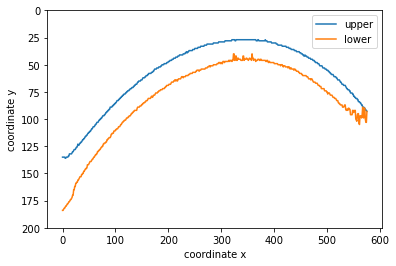

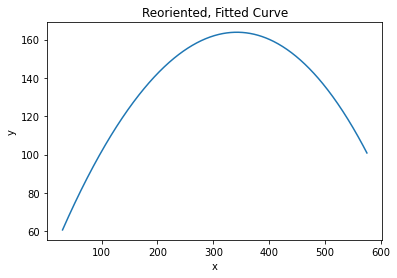

In [25]:
middleOne = getMiddleWaveform("001BA_Left_20160203_132002.avi", 1)
reOriented = (middleOne[0], reOrient(middleOne[1]))
plt.figure()
plt.title("Reoriented, Fitted Curve")
plt.ylabel("y")
plt.xlabel("x")
plt.plot(reOriented[0], reOriented[1])
plt.show()

We test this with an image where the apex is below below the secondary peaks.

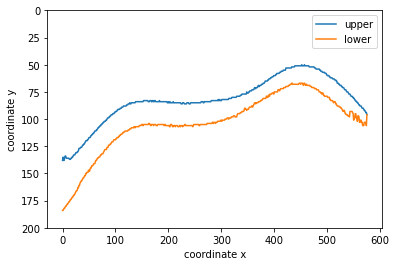

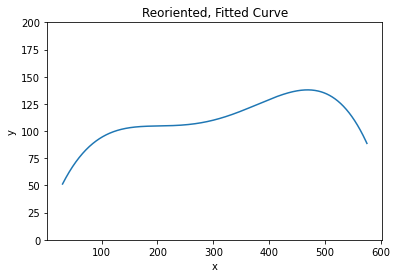

In [26]:
middle60 = getMiddleWaveform("001BA_Left_20160203_132002.avi", 60)
reOriented60 = (middle60[0], reOrient(middle60[1]))
plt.figure()
plt.title("Reoriented, Fitted Curve")
plt.ylabel("y")
plt.xlabel("x")
plt.plot(reOriented60[0], reOriented60[1])
plt.ylim((0,200))
plt.show()    #looks fine?

We make an important observation. The polynomial fitting requires the implicit assumption that our cornea never reaches the stage where the a free node is displaced (far away) beyond the extremities.

Also, from the way our potential energy function is written, it is required that we assume that what we call clamped nodes cannot move horizontally, but only vertically, seeing as we take the horizontal displacement to be zero. 

We write a function to get the displacements and potential energy from stretch of a given frame.

In [34]:
def getFramePotential(videoName, imageNumber, initialLengths, K_arr, output = False, iGuess = np.zeros(N)):
    
    middle = getMiddleWaveform(videoName, imageNumber, output)
    x_nodes = np.linspace(0,575, N+2)
    coefficients = middle[2]
    y_nodes = Polynomial(coefficients, x_nodes)
    
    plt.figure()
    plt.plot(x_nodes,y_nodes)
    plt.show()
    
    displacements = minimize(potentialEnergy, iGuess, args = (x_nodes, y_nodes, initialLengths, K_arr))
    print(displacements.x)
    U_pot = potentialEnergy(displacements.x, x_nodes, y_nodes, initialLengths, K_arr)
    
    return U_pot, displacements.x

In [35]:
def potentialEvolution(videoName, totalImages, increment = 5):   #returns Potential Array (Chronological)
    
    imageNumber = 1
    
    # First, get the initial lengths and stiffnesses.
    
    x_nodes = np.linspace(0,575, N+2)
    
    middle = getMiddleWaveform(videoName, imageNumber, False)
    coefficients = middle[2]
    y_nodes = Polynomial(coefficients, x_nodes)
    
    initialLengths = initialLengthsFinder(x_nodes, y_nodes)
    K_arr = np.ones(N+1)/initialLengths
    
    # Iterate over images and record potential
    
    U_arr = np.zeros(totalImages)
    iGuess = np.zeros(N)
    
    while imageNumber <= totalImages:
        
        print(f'Processing Frame: {imageNumber}')
        U, newGuess = getFramePotential(videoName, imageNumber, initialLengths, K_arr, iGuess)
        U_arr[imageNumber - 1] = U
        imageNumber += increment
        iGuess = newGuess
    
    return U_arr

Let us try to run this on the first video.

In [28]:
potentialArray = potentialEvolution("001BA_Left_20160203_132002.avi", 139)

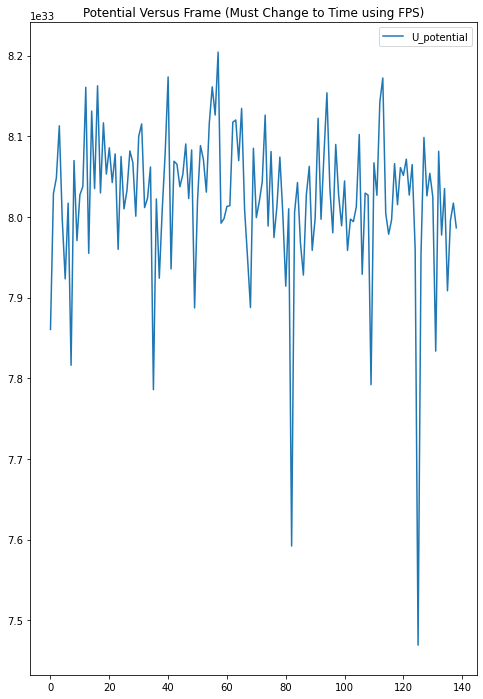

In [38]:
plt.figure(figsize = (8,12))
plt.plot(np.arange(0,139,1), potentialArray, label = "U_potential")
plt.legend()
plt.title("Potential Versus Frame (Must Change to Time using FPS)")
plt.show()

There is division by zero somewhere. Hence, let us run it on a single frame to debug.

In [36]:
imageNumber = 1
videoName = "001BA_Left_20160203_132002.avi"
middle = getMiddleWaveform(videoName, imageNumber, False)
coefficients = middle[2]
x_nodes = np.linspace(0,575, N+2)
y_nodes = Polynomial(coefficients, x_nodes)
    
initialLengths = initialLengthsFinder(x_nodes, y_nodes)
K_arr = np.ones(N+1)/initialLengths

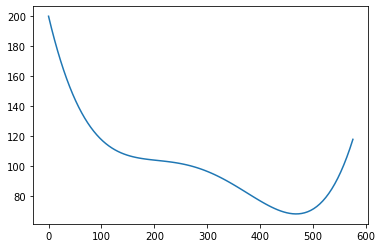

[-1.67289839 -3.1865097  -4.53893677 -5.72941159 -6.7584465  -7.62794915
 -8.34131839 -8.90352393 -9.32111715 -9.60212095 -9.75587224 -9.79287198
 -9.72451492 -9.56270911 -9.31962722 -9.00748634 -8.63815758 -8.22292858
 -7.77240377 -7.29620918 -6.80290131 -6.30010534 -5.79438749 -5.29124981
 -4.79532562 -4.31031221 -3.83905704 -3.38385252 -2.94638732 -2.5277364
 -2.12862831 -1.74947773 -1.39035659 -1.0511935  -0.73179729 -0.43176937
 -0.15068071  0.11183076  0.35621903  0.58298634  0.79249599  0.98506351
  1.16107859  1.32086134  1.46460215  1.59252626  1.70490872  1.80193889
  1.88377625  1.95068819  2.00299037  2.04097056  2.06500021  2.07561174
  2.07341092  2.05905874  2.03338401  1.99739927  1.95221955  1.89908553
  1.83943962  1.77489493  1.70718924  1.63822742  1.57008848  1.50496286
  1.44515993  1.39314133  1.3514425   1.32260858  1.30925193  1.31402335
  1.33944497  1.38786591  1.46150741  1.56233522  1.69188313  1.85119429
  2.04068206  2.25993648  2.50766619  2.78152625  3.

(0.026697889744102157,
 array([-1.67289839, -3.1865097 , -4.53893677, -5.72941159, -6.7584465 ,
        -7.62794915, -8.34131839, -8.90352393, -9.32111715, -9.60212095,
        -9.75587224, -9.79287198, -9.72451492, -9.56270911, -9.31962722,
        -9.00748634, -8.63815758, -8.22292858, -7.77240377, -7.29620918,
        -6.80290131, -6.30010534, -5.79438749, -5.29124981, -4.79532562,
        -4.31031221, -3.83905704, -3.38385252, -2.94638732, -2.5277364 ,
        -2.12862831, -1.74947773, -1.39035659, -1.0511935 , -0.73179729,
        -0.43176937, -0.15068071,  0.11183076,  0.35621903,  0.58298634,
         0.79249599,  0.98506351,  1.16107859,  1.32086134,  1.46460215,
         1.59252626,  1.70490872,  1.80193889,  1.88377625,  1.95068819,
         2.00299037,  2.04097056,  2.06500021,  2.07561174,  2.07341092,
         2.05905874,  2.03338401,  1.99739927,  1.95221955,  1.89908553,
         1.83943962,  1.77489493,  1.70718924,  1.63822742,  1.57008848,
         1.50496286,  1.4451

In [37]:
getFramePotential(videoName, imageNumber+80, initialLengths, K_arr, output = False)

Hence, we've merely stopped the faulty coefficient manipulation and are working with a cornea upside down (which is completely fine.)

Processing Frame: 1


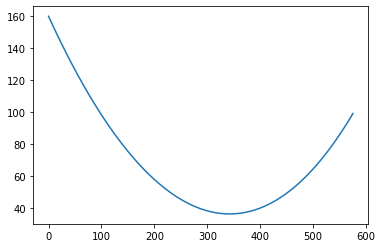

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Processing Frame: 6


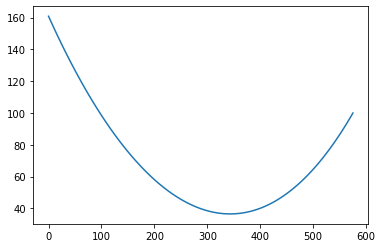

[-0.03070038 -0.05823713 -0.08279785 -0.10451387 -0.12352271 -0.14001575
 -0.154149   -0.16603209 -0.17582203 -0.18369512 -0.18976403 -0.19413767
 -0.19698068 -0.19843231 -0.19857596 -0.19752872 -0.19544179 -0.19241311
 -0.18851228 -0.18385807 -0.17857428 -0.17272505 -0.16637103 -0.15962144
 -0.1525716  -0.14526028 -0.13773375 -0.13008353 -0.12238438 -0.11465627
 -0.10692098 -0.09924493 -0.09169291 -0.08427789 -0.07699099 -0.06985772
 -0.06293179 -0.05624128 -0.04976817 -0.04348486 -0.03739483 -0.03152842
 -0.02590575 -0.02051105 -0.01530117 -0.01023357 -0.00528646 -0.00045803
  0.00424912  0.0088441   0.01335461  0.01782236  0.02229118  0.0267939
  0.03134502  0.03594403  0.04059001  0.04529979  0.05011559  0.0550908
  0.06026008  0.06561989  0.0711439   0.07682392  0.08269051  0.08878142
  0.09509146  0.10157343  0.10819555  0.11497102  0.12190694  0.12895128
  0.13603151  0.14312142  0.15021131  0.1572323   0.16408293  0.17070928
  0.17707275  0.18306872  0.18857231  0.19351439  0.1

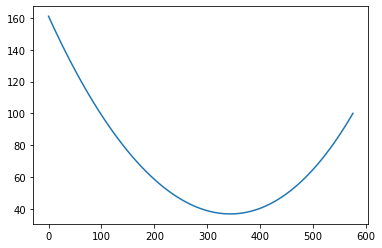

[-0.01405482 -0.02644712 -0.03725993 -0.04656722 -0.05446408 -0.06104744
 -0.06638951 -0.07057321 -0.07370393 -0.07586759 -0.07714045 -0.07762622
 -0.07742252 -0.07659199 -0.07520202 -0.07332522 -0.07099489 -0.06823339
 -0.06509889 -0.06165256 -0.05794235 -0.05404526 -0.05004402 -0.04596404
 -0.04180445 -0.03759223 -0.03335736 -0.02912481 -0.02495322 -0.02090042
 -0.01695799 -0.01309372 -0.00932453 -0.00569268 -0.0022209   0.0010812
  0.00422271  0.00723903  0.01013827  0.01287423  0.01542493  0.01784391
  0.0201825   0.02242147  0.02452891  0.02653363  0.02849496  0.03043265
  0.03232606  0.03417382  0.03602353  0.03792584  0.03988057  0.04186695
  0.04391341  0.04607984  0.04837906  0.05078424  0.05330597  0.05599021
  0.05885383  0.06188586  0.06508549  0.06845382  0.0719927   0.07572626
  0.07965915  0.08373685  0.08792257  0.09224959  0.09672805  0.10129731
  0.1059093   0.11054236  0.11514756  0.11969094  0.12417277  0.12853353
  0.13266118  0.13649515  0.1399936   0.14307319  0.

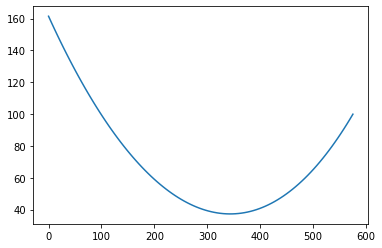

[-0.01039127 -0.01963089 -0.02780746 -0.03498815 -0.04121838 -0.04656912
 -0.05111847 -0.05491072 -0.05799488 -0.06044888 -0.06232788 -0.06366313
 -0.06451594 -0.06495378 -0.06500562 -0.06470642 -0.0641225  -0.06329499
 -0.06223905 -0.06100122 -0.0596353  -0.05815439 -0.05657562 -0.05495083
 -0.05330881 -0.05164625 -0.04999073 -0.04838939 -0.04685025 -0.04537297
 -0.04399927 -0.04276846 -0.04167739 -0.04072863 -0.03995012 -0.03933679
 -0.03884225 -0.03844414 -0.03815398 -0.03796716 -0.03787053 -0.03788796
 -0.03805004 -0.03832725 -0.03865114 -0.0389913  -0.0393631  -0.03977527
 -0.04021551 -0.0406705  -0.04111543 -0.04150102 -0.04179509 -0.0420196
 -0.04220179 -0.04230673 -0.04226668 -0.04205908 -0.04170387 -0.04120321
 -0.0405406  -0.03971765 -0.03872924 -0.03752581 -0.03606424 -0.03436738
 -0.03247633 -0.030391   -0.02811157 -0.02567155 -0.02307876 -0.02030139
 -0.01734146 -0.0142331  -0.0109733  -0.00755273 -0.00401621 -0.0004059
  0.00327774  0.00700345  0.01070442  0.01435296  0.0

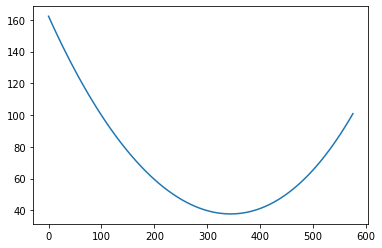

[-0.03239433 -0.06128116 -0.0868741  -0.10933681 -0.12883292 -0.14557271
 -0.15973841 -0.1714684  -0.18093851 -0.18834354 -0.1938228  -0.1975074
 -0.19957595 -0.20018691 -0.1994472  -0.19748893 -0.19447462 -0.19052089
 -0.18571562 -0.18018654 -0.17406662 -0.16743628 -0.16036914 -0.15297856
 -0.14536587 -0.13758244 -0.12968337 -0.12176044 -0.11388967 -0.10609896
 -0.09841644 -0.0909064  -0.08362893 -0.07659811 -0.06980942 -0.06328731
 -0.05707717 -0.0511985  -0.04563014 -0.04034478 -0.03534277 -0.03064451
 -0.02625597 -0.02214837 -0.01827005 -0.01457403 -0.01103511 -0.00764609
 -0.00440039 -0.00127582  0.00177133  0.00480027  0.00787211  0.01103509
  0.0143156   0.01772054  0.02125212  0.02492798  0.02879223  0.03290469
  0.03731177  0.04202373  0.04702446  0.05230909  0.05790728  0.06385844
  0.07016476  0.07678716  0.08369535  0.09089764  0.09839812  0.10614741
  0.11407404  0.12214435  0.1303383   0.1385823   0.14677142  0.15483977
  0.16273226  0.17033348  0.17750884  0.18417033  0.

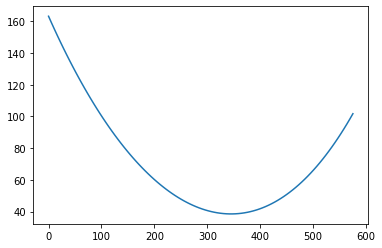

[-0.06100019 -0.11553605 -0.16391849 -0.20647768 -0.24356895 -0.27551044
 -0.30259641 -0.32515562 -0.34351206 -0.35793989 -0.36872153 -0.37616867
 -0.38055373 -0.38211578 -0.38112606 -0.37785513 -0.37252005 -0.36533685
 -0.35655206 -0.34637847 -0.33498681 -0.3225723  -0.30933998 -0.29544243
 -0.28101285 -0.26621877 -0.25121528 -0.23610078 -0.22097229 -0.20596189
 -0.19117715 -0.1766696  -0.1624953  -0.14874627 -0.13549251 -0.12274743
 -0.11052011 -0.09885684 -0.0878005  -0.07734278 -0.06744895 -0.05810953
 -0.04933629 -0.04111555 -0.0333929  -0.02610722 -0.01921945 -0.01269763
 -0.00648568 -0.00050218  0.00533019  0.01106471  0.01674415  0.02242549
  0.02817962  0.03406615  0.04012059  0.04637667  0.05289426  0.0597486
  0.06698995  0.07463299  0.08269705  0.09123547  0.10029989  0.10989169
  0.11998457  0.13058349  0.14171237  0.15334664  0.16541606  0.17787503
  0.19070093  0.2038199   0.21711182  0.23048464  0.24385717  0.25708655
  0.27000175  0.28246631  0.29432463  0.30535797  0.

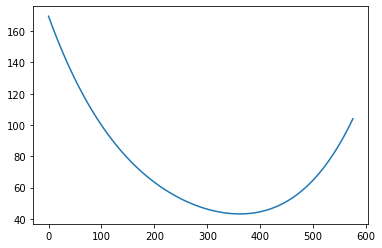

[-0.50339003 -0.95709952 -1.3630881  -1.72335787 -2.03998083 -2.31512262
 -2.55097248 -2.74971501 -2.91360074 -3.04493268 -3.14596559 -3.21892474
 -3.266064   -3.28957494 -3.29153596 -3.27402044 -3.2390909  -3.18868387
 -3.12466226 -3.04886795 -2.96299513 -2.86859238 -2.76720346 -2.66029996
 -2.54918052 -2.43507821 -2.31916885 -2.20245127 -2.08583576 -1.97024173
 -1.85645335 -1.74508086 -1.63671496 -1.53190613 -1.43105918 -1.33451188
 -1.24257657 -1.15544414 -1.07322416 -0.99604122 -0.92394068 -0.85682833
 -0.79460891 -0.7372135  -0.68445627 -0.63605506 -0.59177153 -0.55136204
 -0.51446848 -0.48069994 -0.44971583 -0.42113483 -0.39449192 -0.36934143
 -0.34527669 -0.32184087 -0.29853999 -0.27492223 -0.25055452 -0.22497649
 -0.19773791 -0.16841977 -0.13661599 -0.10196237 -0.06414083 -0.02282074
  0.02230122  0.0714043   0.12461005  0.18206983  0.2438533   0.30987312
  0.37999217  0.45403672  0.53170554  0.61260149  0.69623983  0.78195913
  0.86898387  0.95650925  1.04357365  1.1290046   1

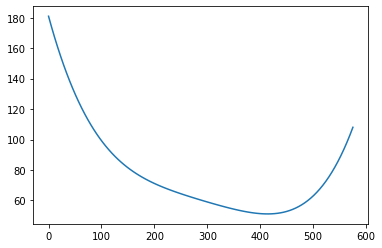

[-1.26040536e+00 -2.40764330e+00 -3.44287681e+00 -4.36784357e+00
 -5.18487018e+00 -5.89684246e+00 -6.50719050e+00 -7.01990497e+00
 -7.43951213e+00 -7.77097561e+00 -8.01962592e+00 -8.19114633e+00
 -8.29147916e+00 -8.32667098e+00 -8.30284139e+00 -8.22617504e+00
 -8.10276216e+00 -7.93850256e+00 -7.73914163e+00 -7.51015555e+00
 -7.25663415e+00 -6.98338409e+00 -6.69490890e+00 -6.39526330e+00
 -6.08813352e+00 -5.77688261e+00 -5.46443392e+00 -5.15336513e+00
 -4.84601285e+00 -4.54433489e+00 -4.24993363e+00 -3.96422752e+00
 -3.68839308e+00 -3.42331628e+00 -3.16972138e+00 -2.92816745e+00
 -2.69899137e+00 -2.48241809e+00 -2.27859022e+00 -2.08746702e+00
 -1.90888795e+00 -1.74268363e+00 -1.58859146e+00 -1.44620318e+00
 -1.31508341e+00 -1.19479192e+00 -1.08478268e+00 -9.84430613e-01
 -8.93120755e-01 -8.10200638e-01 -7.34924455e-01 -6.66521335e-01
 -6.04226193e-01 -5.47209221e-01 -4.94573009e-01 -4.45421848e-01
 -3.98847968e-01 -3.53877754e-01 -3.09502929e-01 -2.64723572e-01
 -2.18521902e-01 -1.69848

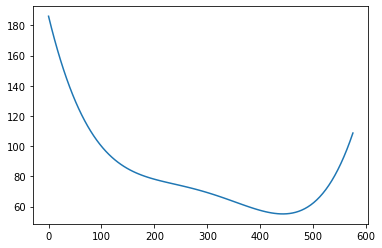

[-1.58577265e+00 -3.03399133e+00 -4.34398221e+00 -5.51587260e+00
 -6.55067991e+00 -7.45036900e+00 -8.21787287e+00 -8.85710528e+00
 -9.37297804e+00 -9.77136336e+00 -1.00589722e+01 -1.02432353e+01
 -1.03322188e+01 -1.03344555e+01 -1.02587210e+01 -1.01139250e+01
 -9.90899582e+00 -9.65262936e+00 -9.35315493e+00 -9.01850842e+00
 -8.65606179e+00 -8.27255445e+00 -7.87417491e+00 -7.46644779e+00
 -7.05417160e+00 -6.64156863e+00 -6.23227284e+00 -5.82930631e+00
 -5.43523212e+00 -5.05214850e+00 -4.68165417e+00 -4.32503055e+00
 -3.98329696e+00 -3.65712300e+00 -3.34692824e+00 -3.05299196e+00
 -2.77540877e+00 -2.51411726e+00 -2.26897658e+00 -2.03973864e+00
 -1.82606232e+00 -1.62759304e+00 -1.44393247e+00 -1.27459321e+00
 -1.11907565e+00 -9.76900101e-01 -8.47526293e-01 -7.30351065e-01
 -6.24784735e-01 -5.30229980e-01 -4.46013832e-01 -3.71414940e-01
 -3.05707833e-01 -2.48122167e-01 -1.97801958e-01 -1.53833454e-01
 -1.15268926e-01 -8.11001082e-02 -5.02302592e-02 -2.14853606e-02
  6.35453829e-03  3.45548

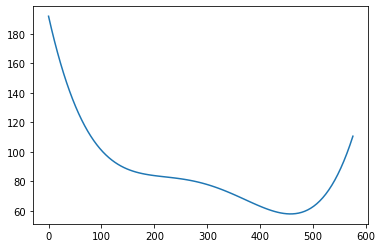

[ -1.84249651  -3.53298199  -5.06875445  -6.44799474  -7.66991694
  -8.73489384  -9.64456754 -10.40195392 -11.01151974 -11.47917099
 -11.81215797 -12.01897845 -12.10925052 -12.0934448  -11.98258974
 -11.788095   -11.52149278 -11.19406373 -10.81666231 -10.39957795
  -9.95225109  -9.48323909  -9.00027198  -8.51006571  -8.01834477
  -7.53001204  -7.04908246  -6.57877371  -6.12171611  -5.67988368
  -5.25464383  -4.84701629  -4.45767402  -4.08690087  -3.73476816
  -3.40119523  -3.0859083   -2.78854965  -2.50873112  -2.24596317
  -1.99972434  -1.76956128  -1.55500589  -1.35553566  -1.17068955
  -1.00007304  -0.84324694  -0.6997499   -0.56917925  -0.45113207
  -0.34513208  -0.25067788  -0.16726903  -0.09433325  -0.03119448
   0.02288596   0.06871121   0.10719831   0.13939154   0.16644316
   0.18960648   0.21024873   0.22987745   0.25014129   0.27277435
   0.29956828   0.33243319   0.37341003   0.42455606   0.48788502
   0.56543351   0.65924416   0.7712288    0.90310533   1.05638284
   1.23226

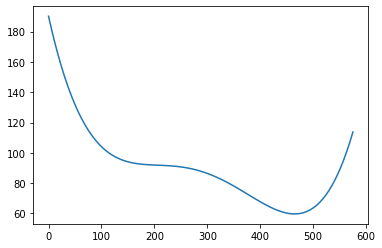

[ -1.80951276  -3.4554772   -4.93478471  -6.24541134  -7.38661713
  -8.35911328  -9.16520755  -9.80892745 -10.29609518 -10.63428562
 -10.8326852  -10.90193166 -10.85388057 -10.70121893 -10.4571033
 -10.13489602  -9.74777042  -9.30832597  -8.82842681  -8.31895576
  -7.78960033  -7.24893851  -6.7043934   -6.16214255  -5.62730408
  -5.10399324  -4.59534373  -4.10377032  -3.63103815  -3.17822935
  -2.74597917  -2.33460825  -1.9440763   -1.57411869  -1.22436221
  -0.89427502  -0.58325469  -0.29074813  -0.01617314   0.24108218
   0.48151273   0.70552721   0.91355895   1.10597594   1.28300578
   1.44485939   1.59177885   1.72393188   1.84142888   1.94444687
   2.03321848   2.10796683   2.16897097   2.21664321   2.25149632
   2.27412819   2.28528229   2.28586848   2.2769402    2.25971364
   2.23558843   2.20612788   2.17306753   2.13833992   2.10403235
   2.07234849   2.04565388   2.0264756    2.01739824   2.02103115
   2.04005985   2.07717861   2.13494926   2.21577392   2.32186992
   2.455124

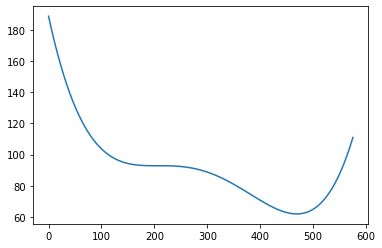

[ -1.80210421  -3.4404299   -4.91188716  -6.21448468  -7.34753882
  -8.31185106  -9.10984384  -9.74567162 -10.22530528 -10.55651039
 -10.74868412 -10.81265674 -10.76048118 -10.60506732 -10.35975577
 -10.03804565  -9.6532594   -9.21809532  -8.74443425  -8.24318748
  -7.724038    -7.19548348  -6.66488664  -6.13833579  -5.62078933
  -5.11624479  -4.62772253  -4.15746317  -3.707087    -3.27754509
  -2.86929643  -2.48252164  -2.11707162  -1.7725185   -1.4483362
  -1.14390074  -0.85849167  -0.59141345  -0.34199372  -0.10954118
   0.10655136   0.30677341   0.49159867   0.66145992   0.81664955
   0.95738724   1.08391347   1.19642271   1.29502185   1.37983178
   1.45103911   1.50883845   1.55343606   1.58513269   1.60435112
   1.61160821   1.60752201   1.59285362   1.56853549   1.53566868
   1.49550163   1.44943773   1.39908312   1.34624773   1.29287462
   1.24102766   1.19296346   1.15111878   1.11799667   1.09614167
   1.08819657   1.096853     1.12473415   1.17435253   1.24806637
   1.347976

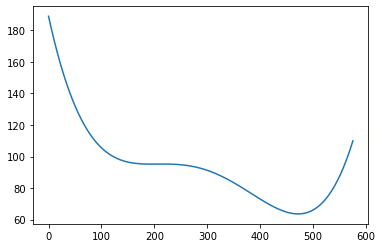

[ -1.76012365  -3.35657854  -4.78657921  -6.04847754  -7.14196925
  -8.06825719  -8.83016737  -9.43225081  -9.88086625 -10.18413192
 -10.35172503 -10.39468558 -10.32521332 -10.15625835  -9.90109516
  -9.57311052  -9.18544367  -8.75052636  -8.27997085  -7.78439228
  -7.27312839  -6.75437975  -6.23523235  -5.72148133  -5.21785374
  -4.72813926  -4.25513962  -3.8009474   -3.36706962  -2.95432026
  -2.56306437  -2.19342806  -1.84518895  -1.51786911  -1.2109273
  -0.92370121  -0.65543524  -0.40544159  -0.17304415   0.04247895
   0.24173377   0.42518897   0.59332954   0.74660183   0.88527775
   1.00956263   1.11970875   1.21590635   1.29823611   1.3668093
   1.42181406   1.46342476   1.4918184    1.50728265   1.51022624
   1.50113363   1.48059053   1.44933561   1.40827143   1.35845892
   1.30111076   1.23759648   1.16948259   1.09854213   1.02668498
   0.95593432   0.88850928   0.82682829   0.77337755   0.7306743
   0.70135573   0.6881429    0.69369066   0.72054697   0.77115079
   0.84772701

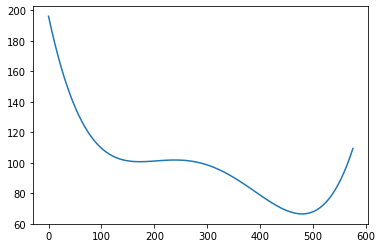

[ -1.89637505  -3.62473802  -5.18106605  -6.56242498  -7.76721057
  -8.79538928  -9.64869594 -10.33078153 -10.84731496 -11.20602224
 -11.41658729 -11.49040985 -11.44032903 -11.28029828 -11.02490714
 -10.68892097 -10.28694665  -9.83298682  -9.34004129  -8.81998457
  -8.2833801   -7.73933795  -7.19563272  -6.65868308  -6.13354993
  -5.62419859  -5.13360624  -4.66380793  -4.21612599  -3.7912727
  -3.38940083  -3.010322    -2.65359873  -2.31850914  -2.00418627
  -1.70975737  -1.43430684  -1.17689598  -0.93666916  -0.71285915
  -0.50476706  -0.31181405  -0.13354872   0.03039296   0.1802656
   0.31619397   0.43823029   0.54638683   0.64060481   0.72077315
   0.78680323   0.83864689   0.87627177   0.89969865   0.90907468
   0.90468054   0.88690106   0.85626089   0.8134951    0.75954615
   0.69551536   0.62268686   0.5425973    0.45702244   0.36790622
   0.27736738   0.18775959   0.10165331   0.0217588   -0.04909763
  -0.10796197  -0.15177889  -0.17744053  -0.18184739  -0.16200268
  -0.1150801

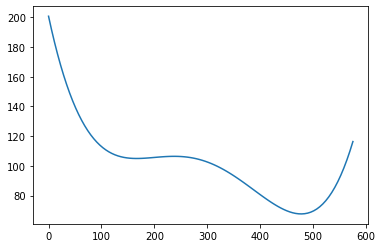

[ -1.95608967  -3.73915823  -5.3443892   -6.76806527  -8.00785914
  -9.0630897   -9.93496035 -10.62676325 -11.14405555 -11.49470689
 -11.68876543 -11.7382476  -11.65688538 -11.45966307 -11.16225035
 -10.78061244 -10.3305416   -9.82705607  -9.28413075  -8.7144625
  -8.12914096  -7.53773803  -6.94835425  -6.36748306  -5.80025108
  -5.25058929  -4.72125055  -4.21412129  -3.73036959  -3.27040878
  -2.8341772   -2.42133531  -2.0311942   -1.66285268  -1.31537737
  -0.98775737  -0.67896571  -0.3880985   -0.11430806   0.14320513
   0.38503087   0.61158494   0.8232503    1.02027137   1.20265221
   1.37031927   1.52320638   1.66111742   1.78372889   1.89076659
   1.98202393   2.05726608   2.11628958   2.15904894   2.18565164
   2.19631551   2.19141517   2.17154427   2.13752777   2.09041433
   2.03146654   1.96217382   1.88430329   1.79990326   1.71122353
   1.62069503   1.53101409   1.44514171   1.36617685   1.29731712
   1.24192708   1.20349815   1.18551415   1.19140146   1.22449784
   1.287931

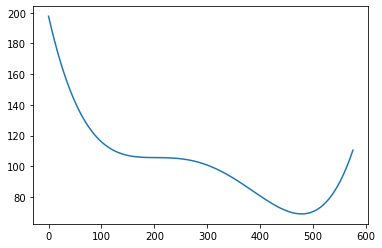

[-1.71896206 -3.27433409 -4.66366597 -5.88568178 -6.94047881 -7.829694
 -8.55661142 -9.12623088 -9.54531297 -9.82233238 -9.96727816 -9.99140386
 -9.90700073 -9.7270447  -9.46475744 -9.13333743 -8.74567549 -8.31392696
 -7.84933262 -7.36213679 -6.86135687 -6.35482194 -5.84927235 -5.35022946
 -4.86212089 -4.38849707 -3.93201403 -3.49458004 -3.07754384 -2.68165945
 -2.30721886 -1.95428064 -1.62263104 -1.31178544 -1.02117815 -0.75020165
 -0.49816506 -0.26438859 -0.04824805  0.15087169  0.33352092  0.5001292
  0.65107709  0.78671053  0.90725792  1.01285507  1.10363934  1.17972626
  1.24115713  1.28796472  1.3202452   1.33812879  1.3417594   1.33135952
  1.30728349  1.26999837  1.22006644  1.15818814  1.0852538   1.00233342
  0.91063597  0.81153007  0.70660874  0.59767884  0.48668145  0.37569208
  0.26700055  0.16309932  0.06657614 -0.01991354 -0.0935939  -0.15159246
 -0.1910296  -0.20907158 -0.20298342 -0.1702035  -0.10838073 -0.0154614
  0.1101027   0.26920635  0.4620392   0.6879094   0.944

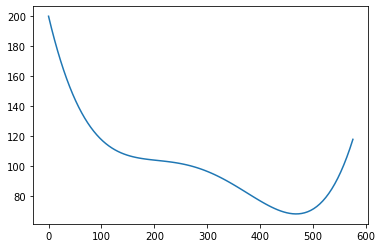

[-1.67289839 -3.1865097  -4.53893677 -5.72941159 -6.7584465  -7.62794915
 -8.34131839 -8.90352393 -9.32111715 -9.60212095 -9.75587224 -9.79287198
 -9.72451492 -9.56270911 -9.31962722 -9.00748634 -8.63815758 -8.22292858
 -7.77240377 -7.29620918 -6.80290131 -6.30010534 -5.79438749 -5.29124981
 -4.79532562 -4.31031221 -3.83905704 -3.38385252 -2.94638732 -2.5277364
 -2.12862831 -1.74947773 -1.39035659 -1.0511935  -0.73179729 -0.43176937
 -0.15068071  0.11183076  0.35621903  0.58298634  0.79249599  0.98506351
  1.16107859  1.32086134  1.46460215  1.59252626  1.70490872  1.80193889
  1.88377625  1.95068819  2.00299037  2.04097056  2.06500021  2.07561174
  2.07341092  2.05905874  2.03338401  1.99739927  1.95221955  1.89908553
  1.83943962  1.77489493  1.70718924  1.63822742  1.57008848  1.50496286
  1.44515993  1.39314133  1.3514425   1.32260858  1.30925193  1.31402335
  1.33944497  1.38786591  1.46150741  1.56233522  1.69188313  1.85119429
  2.04068206  2.25993648  2.50766619  2.78152625  3.

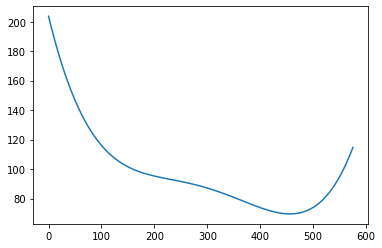

[ -1.66466446  -3.18941259  -4.57310505  -5.81542135  -6.91695677
  -7.87928602  -8.70499819  -9.39774122  -9.96226004 -10.4043514
 -10.73073801 -10.94897532 -11.06737136 -11.09477565 -11.04033967
 -10.91342631 -10.72346007 -10.47962579 -10.19075089  -9.86526868
  -9.51098916  -9.1350408   -8.74397616  -8.34361755  -7.93899455
  -7.53452705  -7.13398856  -6.74047908  -6.35662117  -5.98454603
  -5.625836    -5.28173745  -4.95323369  -4.64093961  -4.34521005
  -4.06626578  -3.80413691  -3.5586962   -3.32975854  -3.11704007
  -2.92015495  -2.73872103  -2.57234246  -2.42053413  -2.28279624
  -2.1586789   -2.0476936   -1.94927942  -1.86289416  -1.78801733
  -1.7240589   -1.67036657  -1.62629389  -1.59116916  -1.56422645
  -1.54462601  -1.5314998   -1.52392356  -1.52086736  -1.52120417
  -1.52375037  -1.52726702  -1.53041376  -1.53173162  -1.52970364
  -1.52280233  -1.5094329   -1.48788672  -1.4564309   -1.41339828
  -1.35713927  -1.28598475  -1.19834046  -1.09277339  -0.96802798
  -0.823068

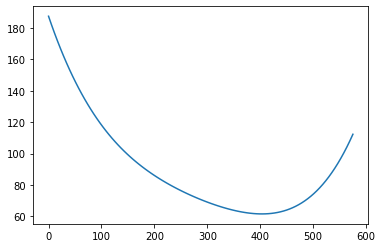

[-0.65595786 -1.23961604 -1.75373542 -2.20127735 -2.58535914 -2.90926828
 -3.17646158 -3.39049126 -3.55496784 -3.67359394 -3.75011792 -3.7882278
 -3.79156106 -3.76372832 -3.70821603 -3.62836751 -3.52746629 -3.40866766
 -3.27490289 -3.12895189 -2.97344144 -2.81075498 -2.64311669 -2.47264635
 -2.30122722 -2.13051235 -1.96203904 -1.79717287 -1.63708329 -1.48284447
 -1.33538412 -1.19540641 -1.06351886 -0.94028724 -0.82611295 -0.72123897
 -0.62585553 -0.54007599 -0.46390149 -0.39726943 -0.34004073 -0.29197057
 -0.25277981 -0.22217432 -0.19975432 -0.18502726 -0.1775159  -0.1767313
 -0.18207746 -0.19290007 -0.20857257 -0.22844502 -0.25178156 -0.27781654
 -0.30580703 -0.33499413 -0.36456998 -0.3937037  -0.4215732  -0.44737186
 -0.47028558 -0.48946884 -0.50408876 -0.51338882 -0.51663999 -0.513068
 -0.50193625 -0.48264539 -0.45465941 -0.4174422  -0.37054988 -0.31368108
 -0.24664066 -0.16937111 -0.08196603  0.01537349  0.12225167  0.2379847
  0.361698    0.49235267  0.62862128  0.76888942  0.9112

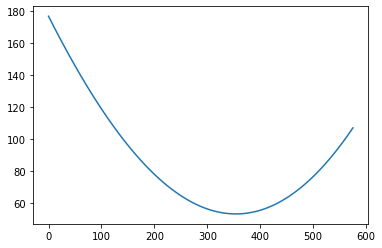

[ 0.15920374  0.3049307   0.43774435  0.55819357  0.66675262  0.76389582
  0.85013225  0.92591606  0.99167577  1.04789964  1.09506145  1.13357928
  1.16390945  1.18651897  1.20178804  1.21008532  1.21183222  1.20740754
  1.19715192  1.18147226  1.16077322  1.13536079  1.10554069  1.07167238
  1.03406711  0.99300226  0.94881681  0.90183272  0.85227222  0.80037197
  0.74643904  0.69073434  0.63345946  0.57485294  0.51515262  0.45452949
  0.3931717   0.33131904  0.2691472   0.20676456  0.14434276  0.08209251
  0.02013367 -0.04145705 -0.1025281  -0.16291762 -0.22254994 -0.28135727
 -0.33920866 -0.39599813 -0.45168791 -0.50620961 -0.55944365 -0.61132381
 -0.66183778 -0.71092035 -0.75846797 -0.80443996 -0.84882945 -0.89157149
 -0.93257847 -0.97181047 -1.00923736 -1.04480082 -1.0784475  -1.11012129
 -1.13973638 -1.16723149 -1.19258137 -1.21569906 -1.23644277 -1.25473734
 -1.27054639 -1.28375724 -1.2942222  -1.30182469 -1.30642879 -1.30789102
 -1.30611253 -1.30094973 -1.29216917 -1.27956834 -1

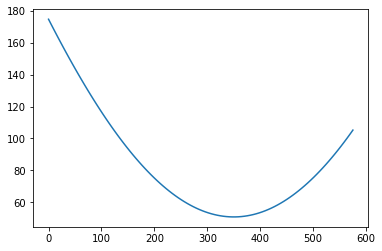

[ 0.17328444  0.32977057  0.47028016  0.59557354  0.70636371  0.80338566
  0.88734838  0.95889835  1.01869693  1.06742399  1.10570882  1.13417059
  1.15346222  1.16419283  1.16690787  1.16216293  1.15050234  1.13240923
  1.10837619  1.07893899  1.04458855  1.00575776  0.96288791  0.91639915
  0.86665271  0.81402764  0.75894347  0.70176339  0.64277975  0.58229293
  0.5206073   0.45799275  0.39472157  0.33106817  0.26723691  0.20338478
  0.13971727  0.07646202  0.0137716  -0.04825538 -0.10949501 -0.16981101
 -0.22910257 -0.28729452 -0.3443211  -0.40013384 -0.45468726 -0.5079266
 -0.55982314 -0.61039043 -0.65963137 -0.70751133 -0.75401825 -0.79920009
 -0.84309888 -0.8856948  -0.92696819 -0.96697088 -1.00576764 -1.04334569
 -1.07966152 -1.11473912 -1.14863016 -1.18131266 -1.21271936 -1.24282431
 -1.2716221  -1.29906906 -1.32509037 -1.34958783 -1.37243855 -1.39354323
 -1.41282377 -1.43012683 -1.4452225  -1.45791083 -1.46801897 -1.47532816
 -1.47959305 -1.48054606 -1.4778467  -1.47113923 -1.

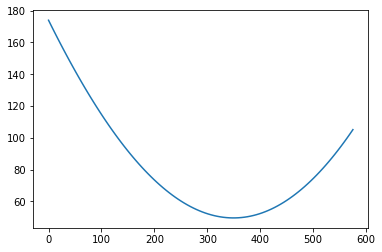

[ 0.11488521  0.21837787  0.31096192  0.39312713  0.46540005  0.52826225
  0.58214667  0.62752091  0.66484665  0.69452156  0.7169618   0.73262575
  0.74192321  0.74524059  0.74301285  0.73564416  0.72345853  0.70679695
  0.68602341  0.6614409   0.63334842  0.60211113  0.56806112  0.53144746
  0.49253411  0.45160295  0.40887829  0.36458633  0.31901129  0.27239073
  0.22487585  0.17664423  0.12791276  0.07884789  0.02959461 -0.01966807
 -0.06880192 -0.11773304 -0.16634129 -0.21446128 -0.26200907 -0.30895978
 -0.35522082 -0.40067118 -0.44527322 -0.48901835 -0.53183837 -0.57367083
 -0.61451676 -0.65436143 -0.69314628 -0.73086074 -0.76754207 -0.80316925
 -0.83768262 -0.87109654 -0.90346141 -0.93474774 -0.96489487 -0.99391881
 -1.02185551 -1.04867174 -1.07432171 -1.09879732 -1.12207032 -1.14409026
 -1.16483695 -1.18426571 -1.202263   -1.2187499  -1.23371041 -1.24705876
 -1.25862961 -1.2682976  -1.27595769 -1.28146019 -1.28466659 -1.28543575
 -1.28353422 -1.27871231 -1.27079316 -1.25957584 -1

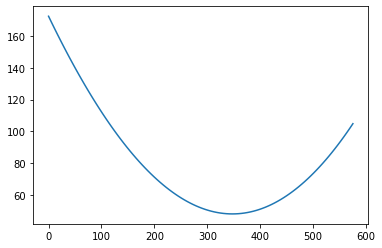

[ 0.06945774  0.13118713  0.18553598  0.23287333  0.27355793  0.30791235
  0.33626938  0.35897437  0.3763381   0.38865778  0.39625228  0.39942397
  0.39844268  0.39359046  0.38515508  0.37338913  0.35853571  0.34085604
  0.32059098  0.29795134  0.27315991  0.24644226  0.21798935  0.18798254
  0.15661998  0.12408221  0.09052149  0.05610128  0.02099322 -0.01465896
 -0.05072186 -0.08704327 -0.12348471 -0.15994933 -0.19634882 -0.23258802
 -0.26860158 -0.30435464 -0.3397892  -0.37481087 -0.40933408 -0.44330385
 -0.47667793 -0.50942666 -0.54154643 -0.57303847 -0.60387206 -0.63399181
 -0.66336157 -0.69198687 -0.71989518 -0.74710182 -0.77359187 -0.79933138
 -0.82429792 -0.8484977  -0.87195149 -0.89467237 -0.91665653 -0.93787751
 -0.95828712 -0.97784607 -0.99655557 -1.0144312  -1.03145052 -1.04755796
 -1.06270203 -1.07682066 -1.08981423 -1.10158433 -1.112069   -1.12119987
 -1.12887286 -1.13498797 -1.13945269 -1.14213514 -1.1428788  -1.14154163
 -1.13796249 -1.13194159 -1.12328783 -1.11181319 -1

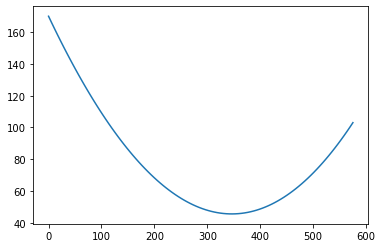

[ 0.04374696  0.08217956  0.11551718  0.14398599  0.16784649  0.18734435
  0.20269813  0.21415474  0.22197082  0.22635803  0.22752195  0.2256893
  0.22104751  0.21374815  0.20397677  0.19192912  0.17776634  0.16166806
  0.1438437   0.12445224  0.10360867  0.08145517  0.05813434  0.03375631
  0.00845937 -0.01759109 -0.04428829 -0.07156725 -0.09932627 -0.12745425
 -0.15587098 -0.18448292 -0.21318947 -0.24194745 -0.27072819 -0.29944027
 -0.32799125 -0.35636162 -0.38453806 -0.41245711 -0.44006607 -0.46735009
 -0.4942816  -0.52082623 -0.54698133 -0.57273807 -0.59805316 -0.6229096
 -0.64733109 -0.67130493 -0.69478254 -0.71776541 -0.7402864  -0.76231997
 -0.78381858 -0.80479666 -0.82527094 -0.84518682 -0.86450281 -0.88324857
 -0.90141541 -0.91891509 -0.93570399 -0.95180067 -0.96715982 -0.98168261
 -0.99532499 -1.00805455 -1.01977779 -1.03040999 -1.03989359 -1.04811223
 -1.05493417 -1.0602951  -1.06410239 -1.06617697 -1.06636845 -1.06456388
 -1.06059566 -1.05429672 -1.04553702 -1.03411566 -1.0

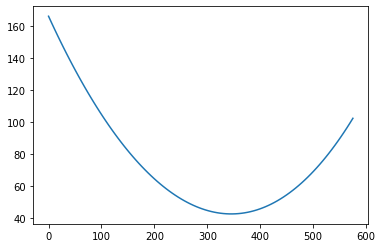

[-3.98841044e-04 -5.49989425e-04 -5.10783960e-04 -3.40233874e-04
 -8.30697168e-05  2.21231106e-04  5.26509849e-04  7.98826057e-04
  1.02109910e-03  1.17097445e-03  1.22430269e-03  1.16911206e-03
  9.83905394e-04  6.22717541e-04  3.71122745e-05 -8.18618162e-04
 -1.99949635e-03 -3.54646120e-03 -5.46297217e-03 -7.74015009e-03
 -1.03797100e-02 -1.33884031e-02 -1.67903836e-02 -2.06377751e-02
 -2.49708792e-02 -2.97841847e-02 -3.50528125e-02 -4.07650518e-02
 -4.69256999e-02 -5.35599468e-02 -6.07010804e-02 -6.83448204e-02
 -7.64429391e-02 -8.49652861e-02 -9.39319705e-02 -1.03366188e-01
 -1.13250180e-01 -1.23540276e-01 -1.34202363e-01 -1.45229012e-01
 -1.56627306e-01 -1.68379512e-01 -1.80426748e-01 -1.92718302e-01
 -2.05254634e-01 -2.18038424e-01 -2.31011378e-01 -2.44097190e-01
 -2.57277886e-01 -2.70558456e-01 -2.83883472e-01 -2.97167091e-01
 -3.10379684e-01 -3.23519404e-01 -3.36524990e-01 -3.49308413e-01
 -3.61841570e-01 -3.74114177e-01 -3.86050334e-01 -3.97566460e-01
 -4.08648178e-01 -4.19271

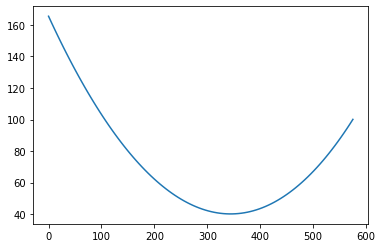

[-0.01383272 -0.02825673 -0.04321875 -0.05866926 -0.07455258 -0.09079823
 -0.10733448 -0.12409421 -0.14100675 -0.1580081  -0.17505806 -0.19213139
 -0.20920503 -0.22626096 -0.24327629 -0.26020363 -0.27698121 -0.29355886
 -0.30990372 -0.32600062 -0.34185531 -0.35747188 -0.3728224  -0.38785842
 -0.40254628 -0.41687911 -0.43086978 -0.44453608 -0.45787205 -0.4708399
 -0.48341224 -0.49560823 -0.50746472 -0.51898801 -0.53015446 -0.54094789
 -0.55138445 -0.56150092 -0.57131606 -0.58081187 -0.58997263 -0.59882929
 -0.60742814 -0.61576794 -0.6238185  -0.63159349 -0.63914467 -0.64648447
 -0.65358016 -0.66043172 -0.66708494 -0.67355354 -0.67980179 -0.68582223
 -0.69165188 -0.69729339 -0.70270411 -0.70787609 -0.71283481 -0.71755801
 -0.7219943  -0.72614183 -0.73000636 -0.73353072 -0.73666273 -0.73940762
 -0.74173503 -0.74355483 -0.74482606 -0.74554331 -0.74562883 -0.74498733
 -0.74358821 -0.74137548 -0.73823586 -0.7341056  -0.72893745 -0.72260579
 -0.71499899 -0.70607029 -0.69571621 -0.68379354 -0.

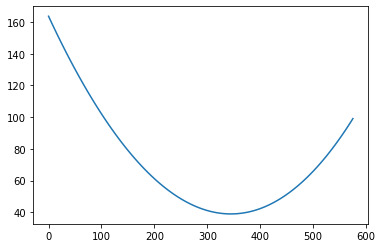

[ 0.01373337  0.02517245  0.03442002  0.0415982   0.04681551  0.05016233
  0.05175525  0.05172266  0.05016689  0.04719527  0.04293649  0.03749152
  0.03093137  0.02334003  0.01479442  0.00534037 -0.00495711 -0.01599476
 -0.02768076 -0.03993668 -0.05267037 -0.06581546 -0.07935375 -0.09325222
 -0.10743598 -0.12183341 -0.13638303 -0.15101993 -0.16571343 -0.18046926
 -0.19525566 -0.20999116 -0.22461993 -0.23913395 -0.25352787 -0.26778473
 -0.28187926 -0.29576536 -0.30940425 -0.32281055 -0.33601126 -0.348972
 -0.36163376 -0.37400159 -0.38612153 -0.39798796 -0.40954672 -0.42078168
 -0.43173205 -0.44241796 -0.45280458 -0.46286118 -0.47261023 -0.48208233
 -0.49125847 -0.50010252 -0.50862014 -0.51683424 -0.52473133 -0.53228073
 -0.53947377 -0.54630655 -0.55276389 -0.55883561 -0.56449852 -0.56969896
 -0.57440947 -0.57864824 -0.58238774 -0.58553434 -0.58803507 -0.58988984
 -0.59105755 -0.5914657  -0.59106313 -0.58977524 -0.58750544 -0.58421254
 -0.57986424 -0.5743549  -0.56757346 -0.55944383 -0.5

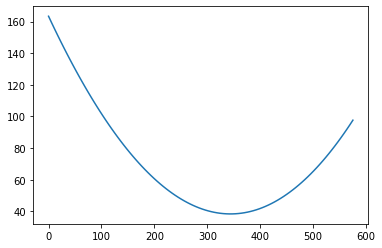

[ 0.02132606  0.03871721  0.05239545  0.06255901  0.06941526  0.07319799
  0.07412322  0.07239075  0.06822113  0.06182468  0.05336749  0.04300997
  0.03092003  0.01723673  0.00209326 -0.0143384  -0.03188221 -0.0503927
 -0.06972658 -0.08974951 -0.11037422 -0.13152175 -0.15306899 -0.17488468
 -0.19686717 -0.21892442 -0.2409813  -0.26299876 -0.28492342 -0.30665293
 -0.3281002  -0.34923841 -0.37005405 -0.3905115  -0.41056812 -0.43017884
 -0.44930763 -0.46796159 -0.48616672 -0.50390001 -0.52111131 -0.5378092
 -0.55404889 -0.5698412  -0.58515045 -0.5999791  -0.61438446 -0.62840519
 -0.64202858 -0.65524789 -0.66810731 -0.68065818 -0.6929027  -0.70482484
 -0.71645299 -0.72783637 -0.73897855 -0.74985601 -0.76048059 -0.77088057
 -0.78104731 -0.7909544  -0.80059026 -0.80993768 -0.81897045 -0.82767143
 -0.83599661 -0.84386006 -0.85120821 -0.85802705 -0.86424091 -0.86971608
 -0.87436233 -0.87811179 -0.88084863 -0.88245045 -0.88280062 -0.88172854
 -0.87905951 -0.87467732 -0.86843589 -0.86012298 -0.8

In [49]:
potentialArray = potentialEvolution("001BA_Left_20160203_132002.avi", 139)

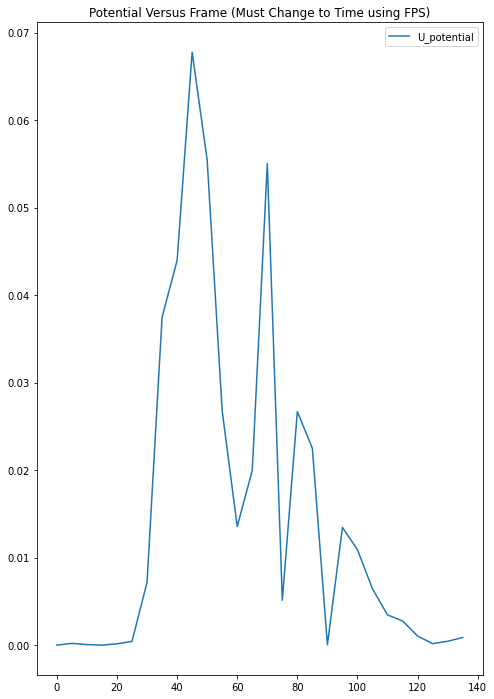

In [54]:
plt.figure(figsize = (8,12))
plt.plot(np.arange(0,139,5), potentialArray[::5], label = "U_potential")
plt.legend()
plt.title("Potential Versus Frame (Must Change to Time using FPS)")
plt.show()